# OULAD : Classification Supervisée et Exportation du Modèle pour Streamlit

Ce notebook effectue une classification supervisée sur le jeu de données Open University Learning Analytics Dataset (OULAD) pour prédire le risque d'abandon scolaire. Les algorithmes utilisés sont Random Forest, XGBoost et SVM. Les performances sont évaluées, et le modèle le plus performant est identifié et exporté pour une utilisation dans une application Streamlit.

In [2]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import joblib

# Configurer le style des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
%matplotlib inline

## Préparation des Données pour la Classification

Sélectionner les caractéristiques pertinentes, normaliser les données et diviser en ensembles d'entraînement et de test.

In [4]:
df = pd.read_csv('/content/oulad_clustering_ready.csv')
df.head()

,gender,highest_education,imd_band,score,total_clicks,age_band_35-55,age_band_55<=,id_student,at_risk
0,-0.907405,1.681820,1.730308,0.633425,-0.166102,-0.638198,12.243101,11391,0
1,1.102043,1.681820,-0.799144,-0.436950,0.129896,1.566911,-0.081679,28400,0
2,1.102043,0.347751,-0.437794,0.000000,-0.551904,1.566911,-0.081679,30268,1
3,1.102043,0.347751,0.284907,0.221742,0.557055,1.566911,-0.081679,31604,0
4,1.102043,-0.986318,0.284907,-1.260315,-0.107021,-0.638198,-0.081679,32885,0


In [5]:


# Sélectionner les caractéristiques pour la classification
features = ['gender', 'highest_education', 'imd_band', 'age_band_55<=','age_band_35-55', 'score', 'total_clicks']
X = df[features]
y = df['at_risk']

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Sauvegarder le scaler pour une utilisation future
joblib.dump(scaler, 'scaler.joblib')
print('Scaler sauvegardé sous scaler.joblib')

Scaler sauvegardé sous scaler.joblib


## Entraînement et Évaluation des Modèles

Entraîner Random Forest, XGBoost et SVM, puis évaluer leurs performances.

In [6]:
# Initialiser les modèles
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Stocker les résultats
results = {}
roc_data = {}

# Entraîner et évaluer chaque modèle
for name, model in models.items():
    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    # Évaluation
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    results[name] = {'report': report, 'auc': auc}
    roc_data[name] = (fpr, tpr)

    # Sauvegarder le modèle
    joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.joblib')
    print(f'Modèle {name} sauvegardé sous {name.lower().replace(" ", "_")}_model.joblib')

# Afficher les résultats
for name, result in results.items():
    print(f'\nRésultats pour {name}:')
    print('Précision:', result['report']['weighted avg']['precision'])
    print('Rappel:', result['report']['weighted avg']['recall'])
    print('F1-Score:', result['report']['weighted avg']['f1-score'])
    print('ROC-AUC:', result['auc'])

Modèle Random Forest sauvegardé sous random_forest_model.joblib


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Modèle XGBoost sauvegardé sous xgboost_model.joblib
Modèle SVM sauvegardé sous svm_model.joblib

Résultats pour Random Forest:
Précision: 0.817692023338306
Rappel: 0.8168430740911182
F1-Score: 0.8169720456847424
ROC-AUC: 0.901341644262496

Résultats pour XGBoost:
Précision: 0.8355581425414654
Rappel: 0.8344838165362786
F1-Score: 0.8346082004111277
ROC-AUC: 0.9164799206574165

Résultats pour SVM:
Précision: 0.8303114737575543
Rappel: 0.8303420770056757
F1-Score: 0.8303239556920295
ROC-AUC: 0.9048356373891351


## Visualisation de l'Importance des Caractéristiques

Afficher l'importance des caractéristiques pour Random Forest et XGBoost.

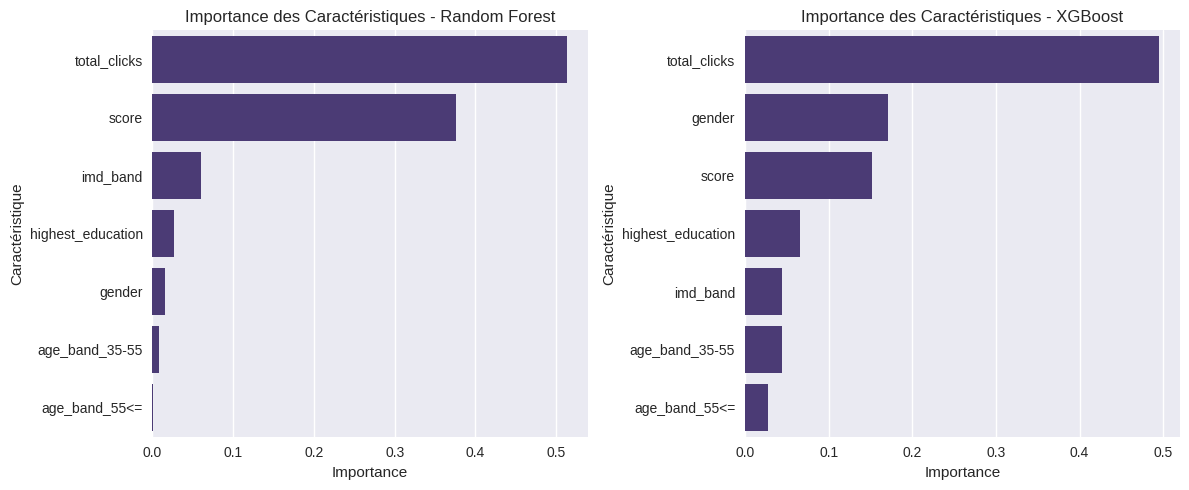

In [7]:
# Importance des caractéristiques pour Random Forest et XGBoost
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, name in enumerate(['Random Forest', 'XGBoost']):
    model = models[name]
    importance = model.feature_importances_
    importance_df = pd.DataFrame({'Caractéristique': features, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    sns.barplot(x='Importance', y='Caractéristique', data=importance_df, ax=axes[idx])
    axes[idx].set_title(f'Importance des Caractéristiques - {name}')
    axes[idx].set_xlabel('Importance')
    axes[idx].set_ylabel('Caractéristique')

plt.tight_layout()
plt.show()

## Courbes ROC

Tracer les courbes ROC pour comparer les performances des modèles.

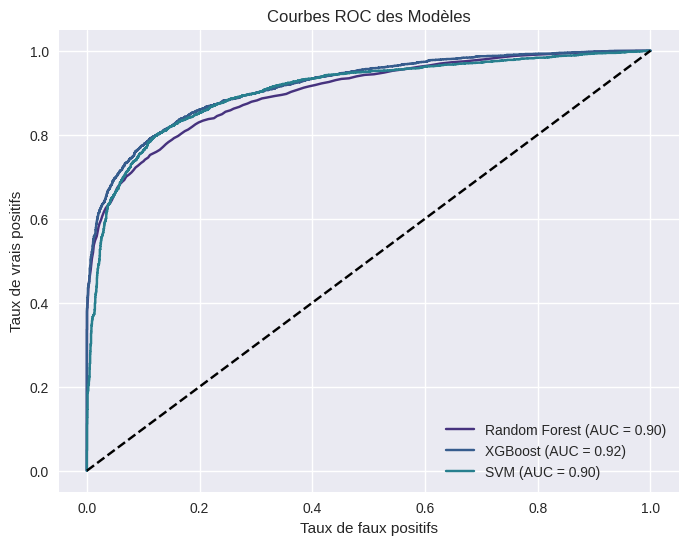

In [8]:
# Tracer les courbes ROC
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC des Modèles')
plt.legend()
plt.show()

## Identification et Exportation du Modèle le Plus Performant

Identifier le modèle avec le meilleur ROC-AUC et confirmer son exportation pour Streamlit.

In [9]:
# Identifier le modèle le plus performant (basé sur ROC-AUC)
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_model_auc = results[best_model_name]['auc']
best_model_file = f'{best_model_name.lower().replace(" ", "_")}_model.joblib'

print(f'Le modèle le plus performant est {best_model_name} avec un ROC-AUC de {best_model_auc:.2f}')
print(f'Modèle déjà sauvegardé sous {best_model_file} pour une utilisation dans Streamlit')
print('Scaler sauvegardé sous scaler.joblib')

# Sauvegarder les résultats d'évaluation
results_df = pd.DataFrame({
    'Modèle': [name for name in results],
    'Précision': [results[name]['report']['weighted avg']['precision'] for name in results],
    'Rappel': [results[name]['report']['weighted avg']['recall'] for name in results],
    'F1-Score': [results[name]['report']['weighted avg']['f1-score'] for name in results],
    'ROC-AUC': [results[name]['auc'] for name in results]
})
results_df.to_csv('classification_results.csv', index=False)
print('Résultats d\'évaluation sauvegardés sous classification_results.csv')

Le modèle le plus performant est XGBoost avec un ROC-AUC de 0.92
Modèle déjà sauvegardé sous xgboost_model.joblib pour une utilisation dans Streamlit
Scaler sauvegardé sous scaler.joblib
Résultats d'évaluation sauvegardés sous classification_results.csv
